In [ ]:
import math
import json
!pip install datasets
from datasets import load_dataset
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Global constants

***TODO: change vocab to list instead of set to maintain order***

In [ ]:
TOKENIZER_DIR = '/content/drive/MyDrive/saved_models/tokenizer_2500_vocab.json'
CHECKPOINT_DIR = '/content/drive/MyDrive/checkpoints/trained_checkpoint/checkpoint.ckpt'
DATASET_DIR = '/content/drive/MyDrive/datasets/tokenized_articles'
LOG_DIR = '/content/drive/MyDrive/logs/training.log'

PAD_TOKEN = '<pad>'
START_TOKEN = '<s>'
END_TOKEN = '</s>'
# how many pairs we want to merge per epoch during tokenizer training
MERGES_PER_EPOCH = 15

# model hyperparamaters
BATCH_SIZE = 64
BUFFER_SIZE = 50_000
train_split = 0.8
validation_split = 0.1
test_split = 0.1
vocab_size = 2500
transformer_units = 6
d_model = 384
seq_length = 256
attention_heads = 8
dff = 1024 # transformer ffn hidden layer size
dropout_rate = 0.1
learning_rate = 1e-6

# Process data

### Loading dataset

In [ ]:
ds = tfds.load('wikipedia/20230601.simple', split='train')

Dl Completed...:   0%|          | 0/7 [00:00<?, ? file/s]

Dataset wikipedia downloaded and prepared to /root/tensorflow_datasets/wikipedia/20230601.simple/1.0.0. Subsequent calls will reuse this data.


In [ ]:
"""
Loads the wikipedia articles.

The database contents are in binary form, we therefore need to decode the strings
using UTF-8 encoding. We then turn all uppercase letters into lowercase. If we
find a category section we remove it. And finally we append the start and end
tokens and save the article.
"""
wiki_articles = list()
for e in ds:
  text = e['text'].numpy().decode('utf-8')
  text = text.lower()
  idx = text.find('category:')
  if idx != -1:
    text = text[:idx]
  wiki_articles.append(text)

In [ ]:
print(wiki_articles[10005])

<s>swedesboro is a borough in gloucester county, new jersey, united states. as of 2010, it had a population of 2,584 inhabitants and a population density of 1,292 people per km².

swedesboro was formed as a borough by an act of the new jersey legislature on april 9, 1902, from portions of woolwich township. the borough was named for its early settlers originally from the colony of new sweden.

history
swedesboro was, at the side of bridgeport, one of only two settlements in what is now new jersey in the colony of new sweden. the oldest existing logging cottage in the united states was built by antti niilonpoika (anthony neilson/nelson) in swedesboro. it is registered as a historic monument, which is also the church of trinity church. this church was founded as a swedish lutheran church 1703; the current building was erected 1784.

the cemetery at the church is the burial ground of the governor of new jersey charles c. stratton and congressman benjamin franklin howey, among other notabl

In [ ]:
book_paragraphs = list()

for i in range(10):
  with open(f'/content/drive/MyDrive/datasets/books/book{i}.txt', 'r') as f:
    for paragraph in f.read().split('\n\n'):
      if len(paragraph) > 50 and 'Gutenberg' not in paragraph:
        paragraph = paragraph.replace('\n', ' ').lower()
        book_paragraphs.append(paragraph)

print('Number of paragraphs:', len(book_paragraphs))

Number of paragraphs: 21151


## Loading CNN data

In [ ]:
# tensorflow has outdated checksums, and therefore we need to download the dataset from Hugging Face
dataset = load_dataset("cnn_dailymail", '3.0.0')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

Combining the dataset splits into one list, excluding highlights and ids.

In [ ]:
articles = list()

for split in ['train', 'validation', 'test']:
  articles.extend(dataset[split]['article'])

In [ ]:
for i, e in enumerate(articles):
  articles[i] = e.lower()

In [ ]:
print(articles[0])

london, england (reuters) -- harry potter star daniel radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on monday, but he insists the money won't cast a spell on him. daniel radcliffe as harry potter in "harry potter and the order of the phoenix" to the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "i don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an australian interviewer earlier this month. "i don't think i'll be particularly extravagant. "the things i like buying are things that cost about 10 pounds -- books and cds and dvds." at 18, radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "hostel: part ii," currently six places below his number one movie on the uk box office chart. details of how

## Training tokenizer

This is an implementation of the Byte-Pair-Encoding algorithm. In which we start with a base vocabulary of tokens. Then we find the most common pair of tokens and merge them into a new token. This process is done iteratively until we reach our desired vocabulary size. However, the encoding algorithm is slightly different from the normal BPE implementation. Instead of iterating over all possible merges and checking them against all tokens, the algorithm checks if adjacent tokens can be merged into a new token that exists in the vocabulary. This process is over 100X faster, in part due to the speed of set lookup. The resulting encodings are sometimes different, however from my observations they shouldn't lead to inferior results.

In [ ]:
base_vocab = 'abcdefghijklmnopqrstuvwxyz!"#$£%&\'()*,-./0123456789:;<>?[\\]{}\n '

In [ ]:
class Tokenizer:
  """
  An implementation of a BPE (Byte-Pair-Encoding) tokenizer.

  The tokenizer allows us to create a token vocabulary size of our choosing while preventing Out-Of-Vocabulary problems. This is done by starting with a base vocabulary comprised of basic characters. The tokenizer then goes over the training corpus, finds the most frequent token pair, and merges them into a new token. This process is done until our desired vocabulary size is reached.

  Attributes:
    vocab_size (int): The maximum of the tokenizer's vocabulary.
    oov_token (str): The predefined Out-Of-Vocabulary token.
    tuple_delimiter (char): The delimiter used to seperate tuple elements when
      serializing the tokenizer.
    vocab (str): the tokenizer's vocabulary.
    reserved_tokens (list[str]): Tokens reserved for other purposes.
    merges (dict[tuple[str], str]): The token merges learned turing training.
  """

  def __init__(self, vocab_size: int, pad_token: str = '<pad>', oov_token: str = '<oov>', reserved_tokens: list[str] = list()) -> None:
    """
    Tokenizer constructor.

    Initializes the tokenizer's attributes and loads the base vocabulary. Training
    the tokenizer is done by calling the ```train_on_corpus``` function, not by
    calling the constructor.

    Args:
      vocab_size: The maximum size of the tokenizer's vocabulary.
      oov_token: The predefined Out-Of-Vocabulary token.
      reserved_tokens: Predefined tokens such as padding, start and end.
    """
    self.vocab_size = vocab_size
    self.oov_token = oov_token
    self.tuple_delimiter = chr(0x1d)

    self.vocab = [pad_token] + [oov_token]
    for token in reserved_tokens:
      self.vocab.append(token)

    self.vocab += list(base_vocab)
    self.vocab_set = set(self.vocab)

    reserved_tokens.append(pad_token)
    reserved_tokens.append(oov_token)
    self.reserved_tokens = reserved_tokens

    self.create_lookup_maps()

    self.merges = dict()


  def tokenize(self, input: str) -> list[int]:
    """
    Tokenizes a string using the tokenizer's learned merge table.

    The input is first split up into base tokens found in the ```base_vocab``` vocabulary. A loop then iterates over the tokens and checks whether the concatenation of adjacent pairs is in the vocabulary. If it is, the tokens are merged. Once the tokenizer can no longer merge tokens, the tokens are vectorized and returned.

    Args:
      input: The string we want to tokenize.

    Returns:
      A list containing the tokenized input in vector form.
    """

    split = [c for c in input if c in self.vocab_set]

    flag = True
    while flag:
      flag = False
      i = 0
      while len(split) - 1 > i:
        merge = split[i] + split[i + 1]
        if merge in self.vocab_set:
          split[i:i+2] = [merge]
          flag = True
        else:
          i += 1

    vectorized = list(map(lambda t: self.token_to_index[t], split))

    return vectorized


  def detokenize(self, input: list[int]) -> str:
    """
    Detokenizes a list of tokens in vector form into a string.

    Each token vector is mapped to its corresponding token. The tokens are then joined together to form the final string.

    Args:
      input: The list of token vectors we want to detokenize.

    Returns:
      A string derived from the input tokens.
    """
    # map each token vector, the index, to its string form
    devectorized = list(map(lambda i: self.index_to_token[i], input))

    return ''.join(devectorized)


  def train_on_corpus(self, corpus: list[str], verbose=False) -> None:
    """
    Trains the tokenizer on a corpus.

    The corpus is first normalized, a process in which characters not present in the base vocabulary are removed. It is then pretokenized, meaning the corpus is split up into words and their frequencies to reduce computation later. After that, the words are split up into their base token representations. Finally we search for the most frequent token pair, merge them into a new token, add it to the vocabulary and merges dictionary, and update our word splits. This is done until our desired vocabulary size is reached.

    In order to reduce training time a number of pairs are merges in each "epoch". These pairs are picked by sorting the pair frequencies by highest lowest.

    Args:
      corpus: The corpus we want to train on. It's recommended to preprocess the
        text before tokenizer training, but not necessary.
    """
    # normalization & pretokenization
    word_freq = dict()
    for e in corpus:
      for word in self.normalize_and_split(e):
        word_freq[word] = word_freq.get(word, 0) + 1

    # initial word split
    splits = { word:[c for c in word] for word in word_freq.keys() }

    # merging
    while len(self.vocab) < self.vocab_size:
      pair_freq = self.calculate_pair_freq(word_freq, splits)
      best_merges = sorted(pair_freq.items(), key=lambda x: -x[1])

      left = self.vocab_size - len(self.vocab)
      for i in range(min(MERGES_PER_EPOCH, left)):
        new_merge = best_merges[i][0]
        self.merges[new_merge] = new_merge[0] + new_merge[1]
        self.vocab.append(new_merge[0] + new_merge[1])
        self.vocab_set.add(new_merge[0] + new_merge[1])
        self.merge_pairs(new_merge[0], new_merge[1], splits)

      if verbose:
        percent = len(self.vocab) / self.vocab_size * 100
        print(f'\rCurrent vocab: {len(self.vocab)}/{self.vocab_size} {percent:.2f}%', end='  ')

    if verbose:
      print()

    self.create_lookup_maps()


  def normalize_and_split(self, text: str) -> list[str]:
    """
    Normalizes a text and splits it by whitespace.

    Characters not found in the tokenizer's base vocabulary are filtered out. The text is then seperated into individual words by whitespace while keeping the delimiter.

    Args:
      text: The string we want to normalize and split.
    """
    text = ''.join([c for c in text if c in base_vocab])
    words = [' ' + word for word in text.split(' ') if word]
    if len(words) > 0:
      words[0] = words[0][1:]  # remove space from first element

    return words


  def calculate_pair_freq(self, word_freq: dict[str, int], splits: dict[str, list[str]]) -> dict[tuple[str, str], int]:
    """
    Calculates all pair frequencies in a pretokenized corpus.

    All token pairs of the pretokenized words are iterated over and their frequency tracked.

    Args:
      word_freq: The pretokenized words with their frequencies.
      splits: The tokens comprising the pretokenized words.

    Returns:
      A dictionary of all token pairs with their respective frequencies.
    """
    pair_freq = dict()
    for word, freq in word_freq.items():
      split = splits[word]
      for pair in zip(split, split[1:]):  # zip adjacent tokens
        pair_freq[pair] = pair_freq.get(pair, 0) + freq

    return pair_freq


  def merge_pairs(self, t1: str, t2: str, splits: dict[str, list[str]]) -> None:
    """
    Merges tokens comprising pretokenized words.

    All token pairs in the pretokenized words are compared against the merge tokens. If a match is found the tokens are compined and replaced with the merged token.

    Args:
      t1: The first token to merge.
      t2: The seconds token to merge.
      splits: The pretokenized words with their token splits.
    """
    for word, split in splits.items():
      i = 0
      while len(split) - 1 > i:
        if split[i] == t1 and split[i + 1] == t2:
          split[i:i+2] = [t1 + t2]
        else:
          i += 1

      splits[word] = split


  def create_lookup_maps(self) -> None:
    """
    Creates mappings for token to index and index to token.

    The vocabulary is enumerated over and the appropriate key and values are placed in a map.
    """
    self.token_to_index = { token:i for i, token in enumerate(self.vocab) }
    self.index_to_token = { i:token for i, token in enumerate(self.vocab) }


  def serialize_to_file(self, file_path: str) -> None:
    """
    Serializes the tokenizer and saves it to a file.

    The tokenizer's attributes are turned into JSON form and then saved to an file. The merges map contains a tuple type which cannot be serialized to JSON. Therefore, we place the tupple elements in a string and separate them with the ```self.tuple_delimiter``` char.

    Args:
      file_path: The file path for saving the serialized file.
    """
    data = dict()
    data['vocab_size'] = self.vocab_size
    data['oov_token'] = self.oov_token
    data['vocab'] = self.vocab
    data['reserved_tokens'] = self.reserved_tokens
    serialized_merges = { k[0]+self.tuple_delimiter+k[1] : v for k, v in self.merges.items() }
    data['merges'] = serialized_merges

    with open(file_path, 'w') as f:
      json.dump(data, f)


  def deserialize_from_file(self, file_path: str) -> None:
    """
    Deserializes the tokenizer from a serialized JSON file.

    The JSON file containing the serialized tokenizer is read from and the tokenizer's attributes are set. The tuples in the merges map are represented as a string with their elements separated by a delimiter. During deserialization we split this string by the delimiter and recreate the tupple.
    """
    with open(file_path, 'r') as f:
      data = json.load(f)
      self.vocab_size = data['vocab_size']
      self.oov_token = data['oov_token']
      self.vocab = data['vocab']
      self.vocab_set = set(self.vocab)
      self.reserved_tokens = data['reserved_tokens']
      serialized_merges = data['merges']
      self.merges = dict()
      for k, v in serialized_merges.items():
        delimiter_idx = k.index(self.tuple_delimiter)
        key = (k[:delimiter_idx], k[delimiter_idx+1:])
        self.merges[key] = v

    self.create_lookup_maps()

  def get_vocab(self):
    return self.vocab

Train the tokenizer and serialize its state. Only the first 100,000 articles are using for training to reduce compute time while keeping good merging accuracy. Only two reserved tokens need to be defined, start of text and end of text, because the constructor has default definitions for padding and out of vocabulary tokens.

In [ ]:
reserved_tokens = [START_TOKEN, END_TOKEN]
tokenizer = Tokenizer(vocab_size, reserved_tokens=reserved_tokens)

# train on the first 100,000 articles to reduce run time and retain good merge accuracy
tokenizer.train_on_corpus(articles[:100_000], verbose=True)

tokenizer.serialize_to_file(TOKENIZER_DIR)

Current vocab: 2500/2500 100.00%  


In [ ]:
tokenizer.serialize_to_file('/content/drive/MyDrive/saved_models/tokenizer_backup.json')

In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.deserialize_from_file(TOKENIZER_DIR)

In [ ]:
a = tokenizer.tokenize(' understand')
print(a)
print(tokenizer.detokenize(a))

[542, 150, 23, 187]
 understand


Evaluating the tokenizer on an excerpt from an article not found in the training set. As we can see, commonly used words are encoded using a single token. Whereas rarer words are split up across multiple tokens. It can also be observed that the tokenizer can detokenize the tokens as intended.

In [ ]:
tokenized = tokenizer.tokenize(' on one hand there are a lot of people who do not understand what is going on')
print(tokenized)
for token in tokenized:
  print(f'{token}=>{tokenizer.detokenize([token])}')
print(tokenizer.detokenize(tokenized))

[128, 332, 894, 367, 200, 69, 1087, 101, 352, 243, 301, 228, 542, 150, 23, 187, 389, 142, 776, 128]
128=> on
332=> one
894=> hand
367=> there
200=> are
69=> a
1087=> lot
101=> of
352=> people
243=> who
301=> do
228=> not
542=> und
150=>ers
23=>t
187=>and
389=> what
142=> is
776=> going
128=> on
 on one hand there are a lot of people who do not understand what is going on


In [ ]:
[128, 332, 894, 367, 200, 69, 1087, 101, 352, 243, 301, 228, 542, 150, 23, 187, 389, 142, 776, 128]
128=> on
332=> one
894=> hand
367=> there
200=> are
69=> a
1087=> lot
101=> of
352=> people
243=> who
301=> do
228=> not
542=> und
150=>ers
23=>t
187=>and
389=> what
142=> is
776=> going
128=> on
 on one hand there are a lot of people who do not understand what is going on

Accessing the tokenizer's speed using Google Colab's built in timeit function. The sentence chosen for this task is an excerpt from an article not found in the training set with appropriate reserved tokens added.

In [ ]:
corpus = ['<s>with that being said, there are many who think that</s><pad>'] * 1000

In [ ]:
%%timeit
for e in corpus:
  tokenizer.tokenize(e)

47.2 ms ± 703 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Create dataset pipeline

The dataset pipeline is created by tokening the articles, splitting them up into sequence-length long chunk and packaging them up in tenorflow's Dataset object. Using a dataset object gives us more control and flexibility, primarily in the way the data is loaded into ram. In order to reduce the dataset's disk space, sequence-length plus one long chunks are stored. When loading the dataset, these chunks are turned into the X and Y values for the function.

In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.deserialize_from_file(TOKENIZER_DIR)

In [ ]:
for i, e in enumerate(articles):
  # overwrite articles with their tokenized form to reduce ram usage
  articles[i] = tokenizer.tokenize(e)
  percent = (i + 1) / len(articles) * 100
  print(f'\rArticles tokenized: {i+1}/{len(articles)} {percent:.2f}%', end='  ')

Articles tokenized: 311971/311971 100.00%  

avg: 1212.4867567818803
mode: 882


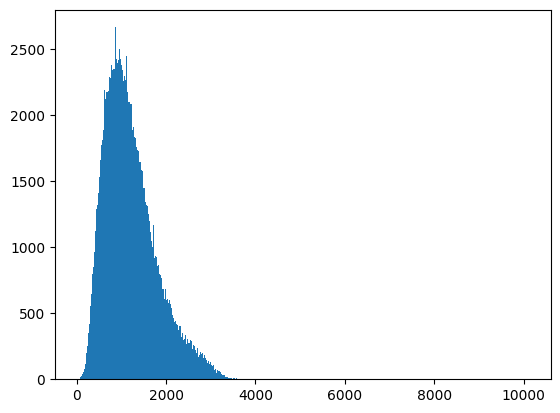

In [ ]:
tokenized_data_lengths = [len(e) for e in articles]

avg = sum(tokenized_data_lengths) / len(tokenized_data_lengths)
print('avg:', avg)
mode = max(set(tokenized_data_lengths), key=tokenized_data_lengths.count)
print('mode:', mode)

plt.hist(tokenized_data_lengths, bins=1000)
plt.show()

In [ ]:
split_length = seq_length + 1
start_token_index = [2]
end_token_index = [3]

padded_data = list()

for e in articles:
  e = start_token_index + e + end_token_index
  e = np.array(e)
  splits = int(math.ceil(len(e) / split_length))
  padding_length = splits * split_length - len(e)

  e = np.pad(e, (0, padding_length))
  padded_data.extend(np.array_split(e, splits))

In [ ]:
print(len(padded_data))

1629583


In [ ]:
np.save('/content/drive/MyDrive/datasets/articles.npy', padded_data)

In [ ]:
padded_data = np.load('/content/drive/MyDrive/datasets/articles.npy')

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(padded_data)

In [ ]:
dataset.save(DATASET_DIR)

# Model

## The transformer

This transformer architecture is based on the architecture first proposed in the "Attention is all you need" paper, with a few changes. Primariliy adding dropout and moving the batch normilzation in front of the Multi-head masked attention layer, and adding one before the feed forward layer.

**Diagram**:

![diagram](https://drive.google.com/uc?export=view&id=1OuqMYRGyUihgPOramyPEEqAhgaji0HBZ)

### Masked multi-head attention

The scaled dot product attention is the core of the transformer architecture. THe attentin model is what allows the transformer to deal with large input sequences without with exploding or vanishing gradients. It's comparable to a search engine where we have a Query which gets compared to a list of Keys of Values. Values that have keys similar to the query get a higher relevance score. The similarity between queries and keys is calculated using a scaled dot product: $\frac{Q\cdot K^T}{\sqrt{d_k}}$. When one of the data dimensions in the queries vector and keys vector is large, it's dot product will also be large. When either or both are small the dot product is small. However, the total dot product grows as the data dimensions grow. Therefore, we need to scale the total dot product by a factor of $\frac{1}{\sqrt{d_k}}$.

A softmax function is then applied across the last dimension.



$Attention(Q,K,V)=softmax(\frac{Q\cdot K^T}{\sqrt{d_k}})\cdot V$

**Diagram:**

![diagram](https://drive.google.com/uc?export=view&id=1sq2NAvfa7ECivIB1fxTn7d4xKP-OGyzZ)

https://jalammar.github.io/illustrated-transformer/

https://nlp.seas.harvard.edu/2018/04/03/attention.html#

Attention is all you need

In [ ]:
def scaled_dot_product_attention(Q, K, V, mask):
  """
  Implementation of scaled dot product attention.

  The shape of the queries, values and keys is not known. We only care about the last two dimensions which must be of shape (tokens, d_k) for the queries and keys, and (tokens, d_v) for the values. This allows us to use the function both for normal attention and for multi head attention. Additionally, this means the function doesn't need batch dimension boilerplate.

  Args:
    Q: the queries. (..., seq_length, d_k)
    K: the keys. (..., seq_length, d_k)
    V: the values. (..., seq_length, d_v)
    mask: a boolean mask of elements not to attend to. (batches, heads, seq_length, seq_length)

  Returns:
    The scaled dot product attention of the queries, keys and values provided. If the input was comprised of multple batches and heads the result will retain the number of batches and heads. (..., seq_length, d_v)
  """
  # matmul transposition uses `tf.linalg.matrix_transpose` which only transposes
  # the inner-most 2d matrix
  x = tf.matmul(Q, K, transpose_b=True) # (..., seq_length, seq_length)

  # scale the dot product with of a factor of 1 over the standard deviation,
  # therefore the standard deviation is now unit
  d_k = Q.shape[-1]
  x /= d_k**0.5

  # apply look-ahead and padding masks, ones represent values we want to keep
  replace_with = tf.expand_dims(tf.ones(x.shape[-1:], dtype=tf.float32) * -1e9, axis=0)
  x = tf.where(mask, x, replace_with)

  # apply the softmax functin across each token, horizontally
  x = tf.nn.softmax(x, axis=-1)

  x = tf.matmul(x, V) # (..., seq_length, d_v)

  return x

This multi-head attention architecture is identical to the one proposed in the "Attention is all you need" paper. The inputs are then split up into groups of size $\frac{d_{model}}{head}$. Each group is projected using learned pojection wegiths into keys, queries and values, which are then feed into a scaled dot product attention. The heads' results are then concatenated across the last dimension and multiplied by a learned proejection weight $O_w$. Dropout is applied to prevent overfitting.


**Diagram**:

![diagram](https://drive.google.com/uc?export=view&id=14ntHSd5lbxq04yVmk_NXnPvDNUz8FzuR)

In [ ]:
class Multi_Head_Attention(tf.keras.layers.Layer):
  """
  Implementation of multi head attention. This model is identical to the one proposed in the "Attention is all you need" paper.

  Attributes:
    supports_masking: tells tensorflow that this layer supports masking.
    d_model: the model's embedding dimension size.
    heads: the number of attention heads to be used.
    d_k: the size of keys and queries vectors.
    d_v: the size of the value vector.
    Q_w: the projection metrix for calculating queries, consists of learned parameters.
    K_w: the projection metrix for calculating keys, consists of learned parameters.
    V_w: the projection metrix for calculating values, consists of learned parameters.
    Q_w: the projection metrix for concatenating the attention heads, consists of learned parameters.
    dropout: the dropout layer.
  """

  def __init__(self, heads, d_model, dropout_rate):
    """
    Creates the Multi_Head_Attentin object.

    Args:
      heads: the number of attention heads we want to use.
      d_model: the model's embedding dimension.
      dropout_rate: the attention mechinism's dropout rate.
    """
    super().__init__()
    self.supports_masking = True

    if d_model % heads != 0:
      raise ValueError('Model embedding dimensions must be divisible by the number of attention heads!')

    self.d_model = d_model
    self.heads = heads

    # in this case d_k and d_v are equal, however that's just for simplicity's sake
    self.d_k = d_model // heads
    self.d_v = d_model // heads

    # Xavier weight initialization
    seed = np.random.randint(1e9, size=1)[0]
    initializer = tf.keras.initializers.GlorotNormal(seed)
    # we need to add a 1 for the batch dimension, tensorflow's matmul doesn't do this for us
    self.Q_w = tf.Variable(initializer(shape=(1, heads, d_model, self.d_k)))
    self.K_w = tf.Variable(initializer(shape=(1, heads, d_model, self.d_k)))
    self.V_w = tf.Variable(initializer(shape=(1, heads, d_model, self.d_v)))
    self.O_w = tf.Variable(initializer(shape=(1, heads * self.d_v, d_model)))

    self.dropout = tf.keras.layers.Dropout(dropout_rate)


  def call(self, inputs, mask=None):
    """
    Applies the multi-head self attention to a given input. Called during forward propagation and inference.

    Args:
      inputs: the layer's inputs, must be in the shape (batches, tokens, d_model).
      mask: an additional mask to ignore padding tokens, if no mask is provided only a causal mask will be applied.
    """

    # add heads dimension to inputs
    inputs = tf.expand_dims(inputs, axis=1) # (batches, 1, tokens, d_model)

    Q = tf.matmul(inputs, self.Q_w) # (batches, heads, tokens, d_k)
    K = tf.matmul(inputs, self.K_w) # (batches, heads, tokens, d_k)
    V = tf.matmul(inputs, self.V_w) # (batches, heads, tokens, d_v)

    # create masks
    seq_len = inputs.shape[-2]
    full_mask = tf.cast(np.tri(seq_len), dtype=tf.bool)
    if mask is not None:
      mask = tf.expand_dims(mask, axis=1) # (batches, 1, seq_len)
      mask = tf.expand_dims(mask, axis=1) # (batches, 1, 1, seq_len)
      mask = tf.tile(mask, tf.constant([1, 1, seq_len, 1])) # (batches, heads, seq_len, seq_len)
      full_mask = full_mask & mask # (batches, heads, seq_len, seq_len)

    x = scaled_dot_product_attention(Q, K, V, full_mask) # (batches, heads, tokens, d_v)

    # concatenate heads
    batches, heads, tokens, d_v = x.shape
    # this line is the root of a bug which took me a week to find
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # batches could be None, we therefore pass -1 so that the batch size is calculated at runtime
    x = tf.reshape(x, (-1, tokens, heads*d_v)) # (batches, tokens, d_model)

    x = self.dropout(x)

    x = tf.matmul(x, self.O_w) # (batches, tokens, d_model)

    return x

### Feed forward network

Each transformer block contains one fully connected feed forward network. The
network is comprised of one dense layer with a `relu` non-linearity, followed by a dense layer of size $d_{model}$. Dropout is applied to prevent overfitting.

In [ ]:
class FeedForwardNetwork(tf.keras.layers.Layer):
  """
  A simple implementation of the feedforward layer found in the "Attention is all you need" paper. The paper suggests implementing the layer using a convelution layer with a kernel of one, however this implemention is based on element-wise dense layers.

  Attributes:
    supports_masking: tells tensorflow that this layer supports masks.
    dense1: the first dense layer in the FFN.
    dense2: the second dense layer in the FFN
    dropout: the dropout layer used to prevent overfitting.
  """

  def __init__(self, dff, d_model, dropout_rate):
    """
    Creates the FeedForwardNetwork object.

    Args:
      dff: the size of the hidden dense layer.
      d_mode: the embedding dimension of the model.
      dropout_rate: the dropout rate used.
    """
    super().__init__()
    self.supports_masking = True

    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
    self.dense2 = tf.keras.layers.Dense(d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)


  def call(self, inputs):
    """
    Applies the feed forward network. Called during forward propagation and inference.

    Args:
      inputs: the layer's inputs, must of of shape (batches, seq_length, d_model)
    """
    x = self.dense1(inputs)
    x = self.dense2(x)
    x = self.dropout(x)

    return x

### Transformer block

The transformer block encapsulates the attention mechanisms and feed forward network along with layer normalization and residual connections into one block. This block's goal is to extract and refine information from the input so that it can be used in the other layers of the network. Encasing the logic into one block allows for easy model configuration. The blocks can be layered atop each other with ease.

![diagram](https://drive.google.com/uc?export=view&id=1OuqMYRGyUihgPOramyPEEqAhgaji0HBZ)

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
"""
Implementation of the full transformer block, consisting of attention mechanisms and a feed forward network along with layer normalization and residual connections.

Attributes:
  supports_masking: tells tensorflow that this layer supports masks.
  layer_norm_1: the first normalization layer.
  residual_connection: the residual connection component. The same object is used twice as it doesn't have learnable parameters.
  layer_norm_2: the second normalization layer.
  feed_forward_network: the trasnformer's feed forward network.
"""

  def __init__(self, attention_heads, dff, d_model, dropout_rate):
    """
    Creates a transformer object.

    Args:
      attention_heads: the desired number of heads in the attention mechanism.
      dff: the size of the hidden layer in the feed forward network.
      dropout_rate: the dropout rate for the different parts of the transformer.
    """
    super().__init__()
    self.supports_masking = True

    self.layer_norm_1 = tf.keras.layers.LayerNormalization()
    self.multi_head_attention = Multi_Head_Attention(attention_heads, d_model, dropout_rate)
    self.residual_connection = tf.keras.layers.Add()
    self.layer_norm_2 = tf.keras.layers.LayerNormalization()
    self.feed_forward_network = FeedForwardNetwork(dff, d_model, dropout_rate)


  def call(self, inputs):
    """
    Applies the trasnformer logic to an input. Used during forward propagation and inference.

    Args:
      inputs: the input matrix, must be of shape (batches, seq_length, d_model)
    """
    norm_1_out = self.layer_norm_1(inputs)
    attention_out = self.multi_head_attention(norm_1_out)
    residual_1_out = self.residual_connection([norm_1_out, attention_out])

    norm_2_out = self.layer_norm_2(residual_1_out)
    ffn_out = self.feed_forward_network(norm_2_out)
    residual_2_out = self.residual_connection([norm_2_out, ffn_out])

    return residual_2_out

## Positional embedding

Positional embedding as proposed in the "Attention is all you need" paper.


$PE(pos, 2i) = \sin (\frac{pos}{10000^{\frac{2i}{d_{model}}}})$

$PE(pos, 2i+1) = \cos (\frac{pos}{10000^{\frac{2i}{d_{model}}}})$

In [ ]:
def positional_encoding(length, depth):
  """
  Creates the positional encoding matrix from  the sinusoidal encoding formulas.

  Args:
    length: number of possible sequence positions.
    depth: the depth of the encoding, equal to the token embedding dimension.
  """
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis] # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :] / depth # (1, depth)

  angle_rates = 1 / (10000**depths) # (1, depth)
  angle_rads = positions * angle_rates # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  pos_encoding = np.expand_dims(pos_encoding, axis=0)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  """
  Implementation of a positional embedding layer based on the sinusoidal encoding formulas from the "Attention is all you need" paper.

  Attributes:
    supports_masking: tells tensorflow that this layer supports masking.
    pe_table: the table containing the positional encoding values.
  """

  def __init__(self, max_length, d_model):
    """
    Creates a PostionalEmbedding object.

    Args:
      max_length: the maximum sequence length.
      d_model: the token embedding dimension.
    """
    super().__init__()
    self.supports_masking = True

    self.pe_table = positional_encoding(max_length, d_model)


  def call(self, inputs):
    """
    Adds the positional embedding values to an input. Called during forward propagatin and inference.

    Args:
      input: the input matrix, must be of shape (batches, seq_length, d_model)
    """
    batches, seq_length, d_model = inputs.shape

    # scale up token embeddings so that they have more influence than positional embedding
    x = inputs * np.sqrt(d_model, dtype=np.float32)

    x = x + 0.1 * self.pe_table[:, :seq_length, :]

    return x

## Complete model

In [ ]:
inputs = tf.keras.Input(shape=(seq_length, ))
# token embedding layer
x = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)(inputs)
# positonal embedding layer
x = PositionalEmbedding(5000, d_model)(x)

for _ in range(transformer_units):
  x = TransformerBlock(attention_heads, dff, d_model, dropout_rate)(x)

x = tf.keras.layers.LayerNormalization()(x)

outputs = tf.keras.layers.Dense(vocab_size)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 384)          960000    
                                                                 
 positional_embedding (Posi  (None, 256, 384)          0         
 tionalEmbedding)                                                
                                                                 
 transformer_block (Transfo  (None, 256, 384)          1379200   
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  (None, 256, 384)          1379200   
 formerBlock)                                                    
                                                             

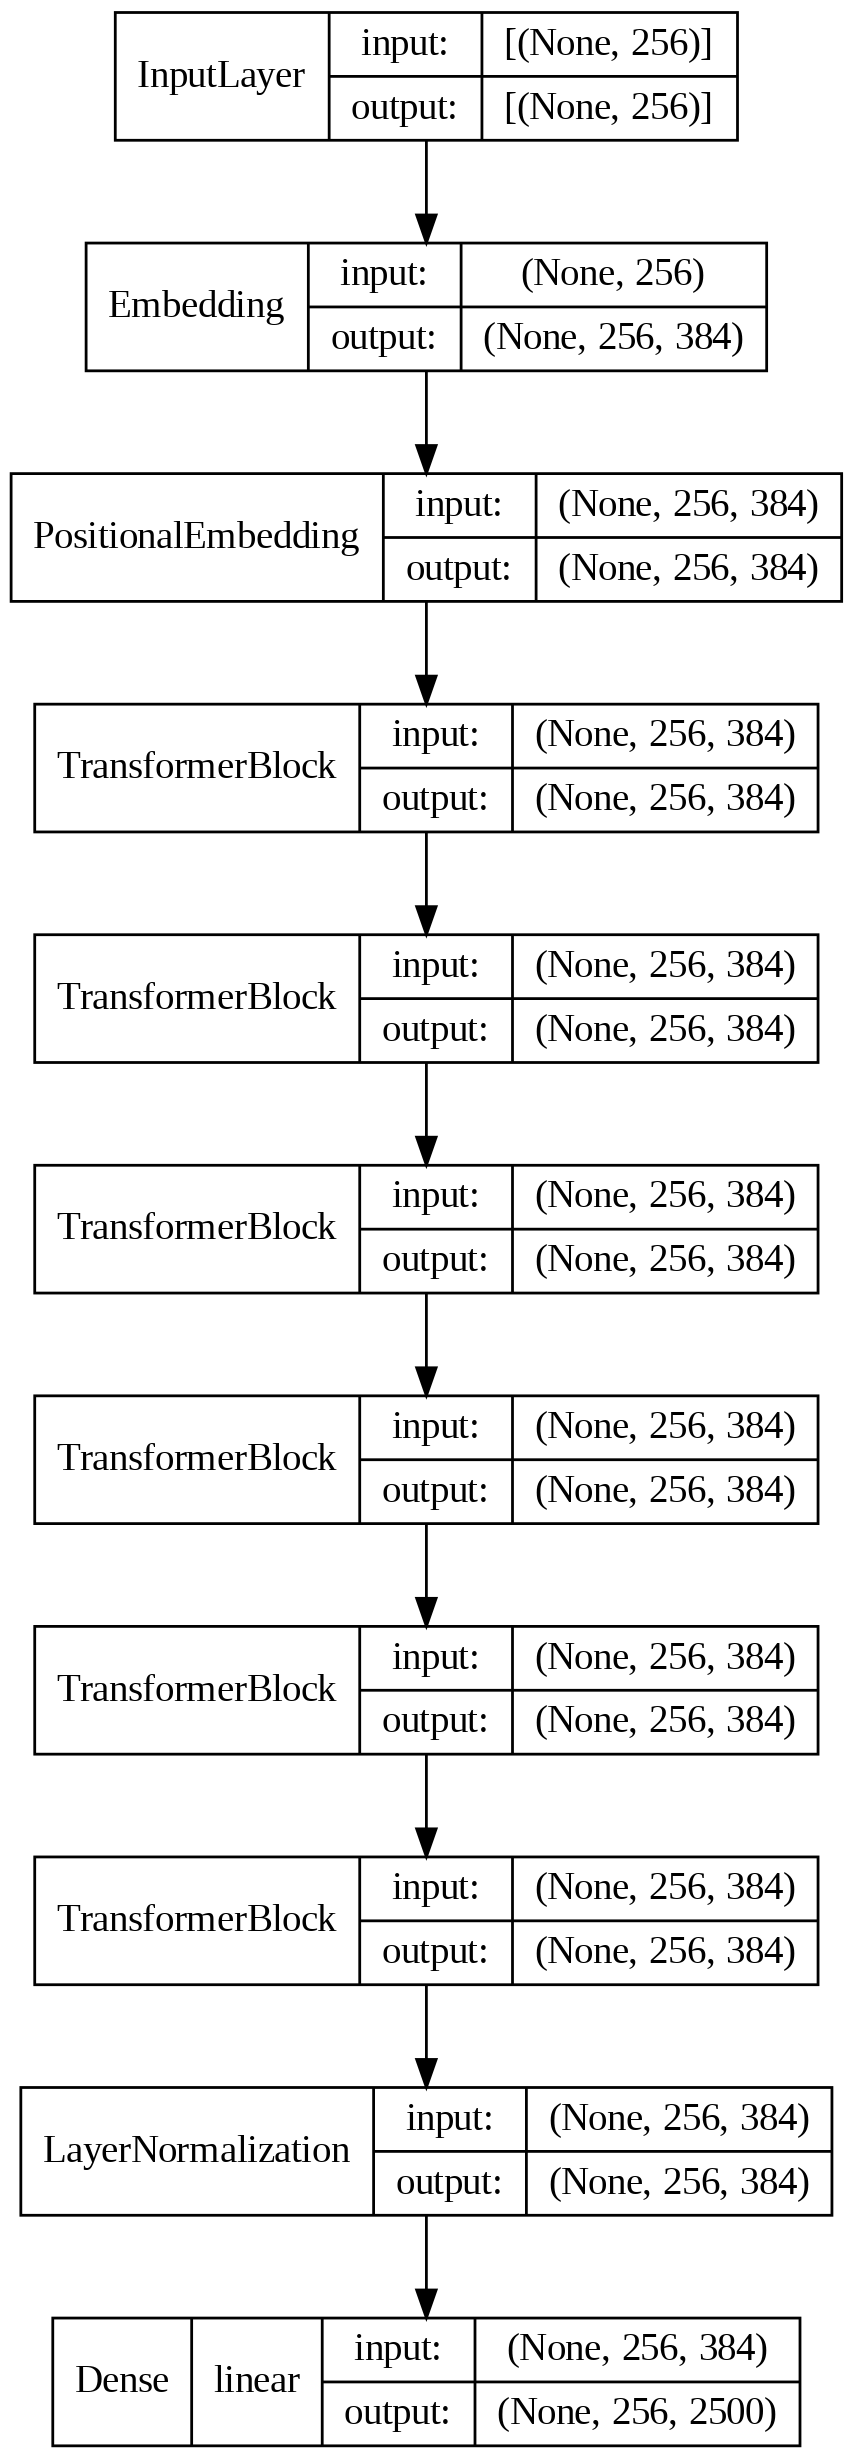

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=False, show_layer_names=False, rankdir='TB', expand_nested=True, show_layer_activations=True, dpi=200)

In [ ]:
custom_objects = {
    'PositionalEmbedding': PositionalEmbedding,
    'TransformerBlock': TransformerBlock,
    'Multi_Head_Attention': Multi_Head_Attention,
    'FeedForwardNetwork': FeedForwardNetwork
}

model = tf.keras.models.load_model(CHECKPOINT_DIR, custom_objects=custom_objects)

OSError: No file or directory found at /content/drive/MyDrive/checkpoints/trained_checkpoint/checkpoint.ckpt

In [ ]:
model.save('/content/drive/MyDrive/checkpoints/full_model/')

In [ ]:
dataset = tf.data.Dataset.load(DATASET_DIR)

preprocess = lambda x: (x[:, :-1], x[:, 1:])
dataset = (dataset
            .batch(BATCH_SIZE)
            .map(preprocess, tf.data.AUTOTUNE)
            .prefetch(buffer_size=tf.data.AUTOTUNE))

size = len(dataset)
training_dataset = dataset.take(int(size * train_split))
dataset = dataset.skip(int(size * train_split))
validation_dataset = dataset.take(int(size * validation_split))
testing_dataset = dataset.skip(int(size * validation_split))

print('training dataset size:', len(training_dataset))
print('validation dataset size:', len(validation_dataset))
print('testing dataset size:', len(testing_dataset))

In [ ]:
log_callback = tf.keras.callbacks.CSVLogger(LOG_DIR, append=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                        filepath=CHECKPOINT_DIR,
                        monitor='val_accuracy',
                        mode='max',
                        save_best_only=True)

callbacks = [log_callback, checkpoint_callback]

history = model.fit(training_dataset,
                    validation_data=validation_dataset,
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)

model.save('/content/drive/MyDrive/saved_models/model_checkpoint_1.keras')

In [ ]:
plt.plot(range(30), model.history.history['loss'], label='Training Loss')
plt.show()

In [ ]:
list(training_dataset.take(1).to_numpy_iterator())

In [ ]:
model.load_weights('/content/drive/MyDrive/checkpoints/test/checkpoint.ckpt').expect_partial()

In [ ]:
print(model.evaluate(testing_dataset.take(10)))

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
             metrics=['accuracy'])

# Inference

In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.deserialize_from_file(TOKENIZER_DIR)

In [ ]:
model.load_weights(CHECKPOINT_DIR)

In [ ]:
text='(CNN) -- At least 14 people were killed and 60 others wounded Thursday when a bomb ripped through a crowd waiting to see Algeria\'s president in Batna, east of the capital of Algiers, the Algerie Presse Service reported. A wounded person gets first aid shortly after Thursday\'s attack in Batna, Algeria. The explosion occurred at 5 p.m. about 20 meters (65 feet) from a mosque in Batna, a town about 450 kilometers (280 miles) east of Algiers, security officials in Batna told the state-run news agency. The bomb went off 15 minutes before the expected arrival of President Abdel-Aziz Bouteflika. It wasn\'t clear if the bomb was caused by a suicide bomber or if it was planted, the officials said. Later Thursday, Algeria\'s Interior Minister Noureddine Yazid Zerhouni said "a suspect person who was among the crowd attempted to go beyond the security cordon," but the person escaped "immediately after the bomb exploded," the press service reported. Bouteflika made his visit to Batna as planned, adding a stop at a hospital to visit the wounded before he returned to the capital. There was no immediate claim of responsibility for the bombing. Algeria faces a continuing Islamic insurgency, according to the CIA. In July, 33 people were killed in apparent suicide bombings in Algiers that were claimed by an al Qaeda-affiliated group. Bouteflika said terrorist acts have nothing in common with the noble values of Islam, the press service reported. E-mail to a friend . CNN\'s Mohammed Tawfeeq contributed to this report.'
text = text.lower()

In [ ]:
tokenized_text = [2] + tokenizer.tokenize(text) + [3]
print(len(tokenized_text))
print(tokenized_text)

443
[2, 762, 217, 167, 1306, 2060, 352, 292, 1170, 105, 843, 45, 1661, 78, 423, 85, 1736, 349, 69, 2147, 439, 1587, 682, 69, 2419, 7, 1759, 1287, 93, 669, 206, 878, 2045, 507, 95, 1433, 2100, 41, 1975, 101, 82, 2038, 101, 206, 10, 1215, 193, 82, 206, 878, 269, 1395, 8, 1430, 509, 514, 69, 78, 423, 85, 888, 498, 22, 485, 69, 114, 1369, 21, 23, 127, 318, 1736, 131, 778, 95, 1433, 2100, 41, 206, 878, 1940, 82, 1147, 237, 115, 1585, 141, 644, 167, 742, 87, 1960, 316, 428, 1398, 150, 382, 51, 50, 397, 152, 39, 212, 69, 179, 22, 1985, 95, 1433, 2100, 41, 69, 1669, 316, 681, 1981, 168, 165, 236, 582, 382, 47, 53, 45, 89, 402, 22, 39, 1975, 101, 206, 10, 1215, 193, 899, 995, 95, 1433, 2100, 470, 82, 603, 42, 556, 17, 964, 2105, 17, 6, 525, 82, 2147, 1265, 279, 1477, 544, 1251, 22, 592, 82, 1898, 1952, 2465, 101, 507, 234, 7, 242, 42, 823, 376, 399, 1251, 9, 590, 14, 732, 151, 2188, 1302, 465, 82, 2147, 157, 1342, 982, 226, 69, 189, 104, 357, 2147, 72, 260, 465, 151, 157, 272, 285, 678, 82, 995

In [ ]:
text = 'it has been reported'.lower()
tokenized = [2] + tokenizer.tokenize(text)
tokenized = tokenized[:256]
window = tokenized + [0] * (seq_length - len(tokenized))
index = len(tokenized) - 1
for _ in range(1000):
  pred = model(np.array([window]))
  token_pred = np.squeeze(pred)[index].astype('float64')
  token_pred *= 1
  token_pred = tf.nn.softmax(token_pred)

  token = np.argmax(np.random.multinomial(1, token_pred))
  print(tokenizer.detokenize([token]), end='')
  if token == 3:
    break

  if len(window) - 1 > index:
    index += 1
    window[index] = token
  else:
    window = window[1:] + [token]

 by former florida state senator dianne m. scotts suggestion of 'horrors' on a candidate seemingly voted interested in u.s. lesbian ted cruz. the bikini of williams has been blamed on a 'bridge wet' overhaul and was thought to have been his previous friend with her daughters 'sweaterwet,' a controversial revolutionary and defiance of youthful separating her from her own clients claimed that she ate for a few seizures online between her two year-old daughters. scroll down for

KeyboardInterrupt: 

In [ ]:
# i state department has said 'the vast majority of the palestinians have been killed', the israeli newspaper reported. the u.s. government has said the government's 'a vast majority of the palestinians have died and the least are injured in the attack'. the u.s. has said the death toll in the israeli town of sharma was the third biggest in the country. the israeli government said the death toll was 'highly inaccurate' and that the palestinians were killed by israeli air strikes in the gaza strip. the palestinians are believed to have died and the palestinians were killed in the attack, the report said. israeli state department said the death toll was 75. the israeli government said the death toll was 75. the palestinians are believed to have died and the palestinians were killed by israeli air strikes in the gaza strip. they said the


In [ ]:
print(list(enumerate([1, 2, 3, 4])))

[(0, 1), (1, 2), (2, 3), (3, 4)]


In [ ]:
window = [2] + [0] * (seq_length - 1)
pred = np.squeeze(model(np.array([window])))
# print(tokenizer.detokenize(np.argmax(pred, axis=-1)))
print(np.argmax(pred, axis=-1))

(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
[1258 1732 1732 1732 1732 1732 1732 1732 1732 1732 1732 1732 1732 1732
 1732 1732 1732 1732 1732 1732 1732 1732 1732 1732 1732 1732 1732 1732
 1732 1732 1732 1732   99   99   99   99   99   99   99   99   99   99
   99   99   99   99   99   99   99   99   99   99   99   99   99   99
   99   99   99   99   99   99   99   99 2143 2143 2143 2143 2143 2479
 2143 2143 2143 2143 2143 2143 2479 2479 2143 2143 2143 2143 2143 2143
 2143 2143 2143 2143 2143 2143 2143 2143 2143 2143 2143 2143 2036 2036
 2036 2036 2036 2036 2036 2036 2036 2036 2036 2036 2036 2036 2036 2036
 2036 2036 2036 2036 2036 2036 2036 2036 2036 2036 2036 2036 2036 2036
 2036 2036 2380 2380 2380 2380 2380 2380 2380 2380 2380 2380 2380 2380
 2380 2380 2380 2380 2380 2380 2380 2380 2380 2380 2380 2380 2380 2380
 2380 2380 2380 2380 2380 2380  922  922  922  922  922 1645 1645  922
  922  922 1198 1198 1645 1645 1645 1645 1645 1645 1645 1645 1645 1645
 1645 1645 1645 1645 16

# Random testing

In [ ]:
data_entry = None
for e in dataset.batch(2):
  data_entry = e
  break

In [ ]:
a = None
for e in dataset.take(1):
  a = e

x_true, y_true = a

x_true = tf.expand_dims(x_true, 0)

In [ ]:
print(x_true)

tf.Tensor(
[[  2   6 195  98  22  54 378 919  82 435 300   7  24 751 197 753  15  18
  268   4 138 619  40 572 806 193 971 145  88  71 134  15 437  64  64  64
   64  64  64  64  64 666 171 741  85 313 169   9  73 147  93 378 168  42
  196  82 435 456 279  83 180 591  41   6  66 369  85 139  64  64  64  64
   64  64  64  64 538 333 736 261  73 221  64  85  98 564  67  25 821 317
  134  41  15 437  64  64  64  64  64  64  64  64  64  64  64  64  64  64
   64  64  64  75  23  16  15  82 435 300   7  24 751 197  94 381 127  69
  127  10  79   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0  

In [ ]:
x_true = tf.constant([[2, 6, 195, 98, 22, 54, 378, 919, 82, 435, 300, 7, 24, 751, 197, 753, 15, 18 , 268, 4, 138, 619, 40, 572, 806, 193, 971, 145, 88, 71, 134, 15, 437, 64, 64, 64 , 64, 64, 64, 64, 64, 666, 171, 741, 85, 313, 169, 9, 73, 147, 93, 378, 168, 42 , 196, 82, 435, 456, 279, 83, 180, 591, 41, 6, 66, 369, 85, 139, 64, 64, 64, 64 , 64, 64, 64, 64, 538, 333, 736, 261, 73, 221, 64, 85, 98, 564, 67, 25, 821, 317 , 134, 41, 15, 437, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64 , 64, 64, 64, 75, 23, 16, 15, 82, 435, 300, 7, 24, 751, 197, 94, 381, 127, 69 , 127, 10, 79, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0, 0]])

In [ ]:
print(model(data_entry[0]).shape)

(2, 256, 1000)


In [ ]:
mask = tf.constant([[[True, False], [True, False]], [[True, True], [True, True]]])
print(mask.shape)
a = tf.constant([[[[1, 2], [3, 4]], [[1, 2], [3, 4]]]], dtype=tf.float32)
print(a.shape)
b = tf.ones(a.shape[-2:], tf.float32) * -1e9

x = tf.where(mask, a, b)
print(x)

(2, 2, 2)
(1, 2, 2, 2)
tf.Tensor(
[[[[ 1.e+00 -1.e+09]
   [ 3.e+00 -1.e+09]]

  [[ 1.e+00  2.e+00]
   [ 3.e+00  4.e+00]]]], shape=(1, 2, 2, 2), dtype=float32)


In [ ]:
mask1 = tf.constant([[True, False, False], [True, True, False], [True, False, False]])
mask2 = tf.cast(np.tri(3), dtype=tf.bool)

mask = mask1 & mask2
print(mask)

tf.Tensor(
[[ True False False]
 [ True  True False]
 [ True False False]], shape=(3, 3), dtype=bool)


In [ ]:
epochs = 2
batch_size = 5

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(dataset.take(100).batch(batch_size)):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        print("Training loss (for one batch) at step %d: %.4f" % (step, float(loss_value)))
        print("Seen so far: %s samples" % ((step + 1) * batch_size))

In [ ]:
mask = tf.constant([[True, True, False], [True, False, False]]) # (batch, mask)
mask = tf.repeat(mask, 3, axis=0) # (batch, mask, mask)
print(mask.shape)
print(mask)

(6, 3)
tf.Tensor(
[[ True  True False]
 [ True  True False]
 [ True  True False]
 [ True False False]
 [ True False False]
 [ True False False]], shape=(6, 3), dtype=bool)


In [ ]:
tri_mask = tf.cast(np.tri(3), dtype=tf.bool)
# tri_mask = tf.expand_dims(tri_mask, axis=0)
# tri_mask = tf.
print(tri_mask.shape)
print(tri_mask)

(3, 3)
tf.Tensor(
[[ True False False]
 [ True  True False]
 [ True  True  True]], shape=(3, 3), dtype=bool)


In [ ]:
mask = tf.constant([[[True, True, True]], [[True, True, False]]])
print(mask.shape)
b = tf.constant([1, 3, 1], tf.int32)
mask = tf.tile(mask, tf.constant([1, 3, 1]))
print(mask.shape)
print(mask)

(2, 1, 3)
(2, 3, 3)
tf.Tensor(
[[[ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True False]
  [ True  True False]
  [ True  True False]]], shape=(2, 3, 3), dtype=bool)


In [ ]:
full_mask = mask & tri_mask
print(full_mask)

tf.Tensor(
[[[ True False False]
  [ True  True False]
  [ True  True  True]]

 [[ True False False]
  [ True  True False]
  [ True  True False]]], shape=(2, 3, 3), dtype=bool)


In [ ]:
mask = tf.constant([[True, False, False]])
mask = tf.expand_dims(mask, axis=1)
print(mask.shape)
b = tf.constant([1, 3, 1], tf.int32)
mask = tf.tile(mask, b)

print(mask.shape)
print(mask)

(1, 1, 3)
(1, 3, 3)
tf.Tensor(
[[[ True False False]
  [ True False False]
  [ True False False]]], shape=(1, 3, 3), dtype=bool)


In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(5)])

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=10, kernel_size=1, activation='relu'),
    tf.keras.layers.Conv1D(filters=5, kernel_size=1)])

In [ ]:
dense1 = tf.keras.layers.Dense(10, activation='relu')
dense2 = tf.keras.layers.Dense(5)

def model1(x):
  x = dense1(x)
  return dense2(x)

In [ ]:
input1 = np.array([[
    [1., 0., 0., 0., 0.],
    [1., 0., 0., 0., 0.],
    [1., 0., 0., 0., 0.]]])

input2 = np.array([[
    [1., 0., 0., 0., 0.],
    [1., 0., 0., 1., 0.],
    [1., 0., 0., 1., 0.]]])

In [ ]:
input1.shape

(1, 3, 5)

In [ ]:
print('model1: ', model1(input1))
print('model2: ', model2(input1))

model1:  tf.Tensor(
[[[ 0.0973601  -0.01921852 -0.24813573 -0.31107447  0.20160046]
  [ 0.0973601  -0.01921852 -0.24813573 -0.31107447  0.20160046]
  [ 0.0973601  -0.01921852 -0.24813573 -0.31107447  0.20160046]]], shape=(1, 3, 5), dtype=float32)
model2:  tf.Tensor(
[[[-0.18823999  0.42539167  0.24561214 -0.3076089   0.32815677]
  [-0.18823999  0.42539167  0.24561214 -0.3076089   0.32815677]
  [-0.18823999  0.42539167  0.24561214 -0.3076089   0.32815677]]], shape=(1, 3, 5), dtype=float32)


In [ ]:
print('model1: ', model1(input2))
print('model2: ', model2(input2))

model1:  tf.Tensor(
[[[ 0.0973601  -0.01921852 -0.24813573 -0.31107447  0.20160046]
  [ 0.12055966  0.04097506 -0.09912045 -0.12655932 -0.05822828]
  [ 0.12055966  0.04097506 -0.09912045 -0.12655932 -0.05822828]]], shape=(1, 3, 5), dtype=float32)
model2:  tf.Tensor(
[[[-0.18823999  0.42539167  0.24561214 -0.3076089   0.32815677]
  [ 0.57166004 -0.12346924  0.21832593  0.20915633  0.18604334]
  [ 0.57166004 -0.12346924  0.21832593  0.20915633  0.18604334]]], shape=(1, 3, 5), dtype=float32)
